In [1]:
import rpy2
import scipy
import logging
import warnings
import anndata
import anndata2ri
import pandas as pd
import scanpy as sc
import numpy as np
import seaborn as sb
import decoupler as dc
import scrublet as scr
import decoupler as dc
from scipy import sparse
from anndata import AnnData
from tabnanny import verbose
import matplotlib.pyplot as plt
from gsva_prep import prep_gsva
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from typing import Optional, Union
from matplotlib.pyplot import rcParams
from functions import pathway_analyses
from statsmodels.stats.multitest import multipletests
from sklearn.model_selection import train_test_split
from pytorch_lightning.loggers import TensorBoardLogger
from rpy2.robjects.conversion import localconverter

In [2]:
def get_sys_dpi(width, height, diag):
    '''
    obtain dpi of system
    
    w: width in pixels (if unsure, go vist `whatismyscreenresolution.net`)
    h: height in pixels
    d: diagonal in inches
    '''
    w_inches = (diag**2/ (1 + height**2/width**2))**0.5
    return round(width/w_inches)

In [3]:
# # Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# # Automatically convert rpy2 outputs to pandas dataframes
# pandas2ri.activate()
# anndata2ri.activate()
# %load_ext rpy2.ipython

warnings.filterwarnings("ignore", category=PendingDeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

rcParams['figure.dpi'] = get_sys_dpi(1512, 982, 14.125)
#rcParams['figure.figsize']=(4,4) #rescale figures

sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()



-----
anndata     0.8.0
scanpy      1.9.1
-----
OpenSSL                     22.0.0
PIL                         9.2.0
absl                        NA
anndata2ri                  1.1
appnope                     0.1.2
asttokens                   NA
astunparse                  1.6.3
attr                        21.4.0
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
boto3                       1.26.32
botocore                    1.29.32
bottleneck                  1.3.5
brotli                      NA
certifi                     2022.09.24
cffi                        1.15.1
cloudpickle                 2.2.0
colorama                    0.4.4
cryptography                38.0.1
cycler                      0.10.0
cython_runtime              NA
dask                        2022.11.0
dateutil                    2.8.2
debugpy                     1.5.1
decorator                   5.1.1
decoupler                   1.4.0
defusedxml                  0.7.1
de

# **Consensus network Visualization**

Here, we perform consensus co-expression network analysis using `hdWGCNA`. 

Consensus co-expression network analysis differs from the standard co-expression network analysis workflow by `constructing individual networks across distinct datasets`, and `then computing an integrated co-expression network`. 

This framework can be used to `identify networks that are conserved across a variety of biological conditions`, and it can also be used as a way to construct a unified network from any number of different datasets. 

Here, use this framework to identify consensus coexpression network of genes across celltypes (from the three studies) in AD.

- [**Morabito et al. bioRxiv 2022**](https://www.biorxiv.org/content/10.1101/2022.09.22.509094v1)
- [**Morabito & Miyoshi et al. Nature Genetics 2021**](https://www.nature.com/articles/s41588-021-00894-z)


In [ ]:
%%R
suppressPackageStartupMessages({
    library(WGCNA)
    library(Matrix)
    library(viridis)
    library(harmony)
    library(ggpubr)
    library(tictoc)
    library(RColorBrewer)
    library(Hmisc)
    library(corrplot)
    library(grid)
    library(gridExtra)
    library(igraph)
    library(ggrepel)
    library(conflicted)

    # single-cell analysis package
    library(Seurat)

    # plotting and data science packages
    library(tidyverse)
    library(cowplot)
    library(patchwork)

    # co-expression network analysis packages:
    library(WGCNA)
    library(hdWGCNA)

    # gene enrichment packages
    library(enrichR)
    library(GeneOverlap)


    library(GSEABase)
    library(GSVA) 
# needs to be run every time you start R and want to use %>%
})

# using the cowplot theme for ggplot
theme_set(theme_cowplot())

# set random seed for reproducibility
set.seed(12345)

# optionally enable multithreading
# enableWGCNAThreads(nThreads = 4)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

## **Prepare data**

Now, we load the preprocessed and annotated data for downstream analysis.

In [5]:
map_meta = True
deg_method =  'DESeq2-Wald'
test_names = ['late_vs_early', 'early_vs_no', 'late_vs_no', 'ad_vs_no']
filter_genes = "TRUE"
studies = ['allen_mtg', 'leng_sfg', 'leng_etc']
subject_id = {'allen_mtg': 'individualID',
             'leng_sfg': 'PatientID',
             'leng_etc': 'PatientID'}      # for leng this is `PatientID` for mathys is 'Subject', and 'individualID' for allen

gene_celltype_threshold = 0.05      # determines number of cells the gene must be expressed in 
covariates = ['None']               # list of covariates to be accounted for in regression.
gene_selection = 'custom'           # specifies the gene selection method when setting up seurat object for WGCNA. The th
celltypes = ["Inhibitory"]          #["Excitatory", "Inhibitory", "Astrocyte", "Microglia", "Oligodendrocyte", "OPC"]
gene_selection = 'fraction'     # specifies the gene selection method when setting up seurat object for WGCNA. The th
                                # Posible values are "custom", "fraction", "variable"
                                # If custom, a list of genes must be passed.

In [ ]:
# convert nested list of anndata object into Rpy2 object 
subject_id =  robjects.ListVector(
                        {
                            save_prefix: subject_id[save_prefix]
                     
                            for save_prefix in studies
                        }
                    )

## **Load Seurat object for Network Visualizations**

In [ ]:
%%R -i subject_id -i gene_celltype_threshold -i celltypes -i test_names -i save_prefix -i gene_selection -o seurat_obj

seurat_obj <- list()

for (cell_type in celltypes) {
    
    print(paste0('Loading data for hdWGCNA Experiment in ', toupper(cell_type)))
    tryCatch({
        seurat_obj[[cell_type]] <- readRDS(paste0("../results/hdWGCNA/SeuratObject/Consensus/", cell_type, '_hdWGCNA_object.rds'))
        print(seurat_obj[[cell_type]])
    
    }, error = function(e){
        NULL
    }, message = function(m){
        print(paste0('Could not load data for ', toupper(cell_type)))
    })

}

print('loaded data')

[1] "Loading data for hdWGCNA Experiment in EXCITATORY"
An object of class Seurat 
16585 features across 10449 samples within 1 assay 
Active assay: originalexp (16585 features, 2000 variable features)
 3 dimensional reductions calculated: pca, harmony, umap
[1] "Loading data for hdWGCNA Experiment in INHIBITORY"
An object of class Seurat 
16585 features across 5207 samples within 1 assay 
Active assay: originalexp (16585 features, 2000 variable features)
 3 dimensional reductions calculated: pca, harmony, umap
[1] "Loading data for hdWGCNA Experiment in ASTROCYTE"
An object of class Seurat 
16585 features across 5851 samples within 1 assay 
Active assay: originalexp (16585 features, 2000 variable features)
 3 dimensional reductions calculated: pca, harmony, umap
[1] "Loading data for hdWGCNA Experiment in MICROGLIA"
An object of class Seurat 
16585 features across 5892 samples within 1 assay 
Active assay: originalexp (16585 features, 2000 variable features)
 3 dimensional reductions 

In [ ]:
# convert nested list of Seurat object into Rpy2 object 
seurat_obj =  robjects.ListVector(
                        {
                            cell_type: seurat_obj[cell_type]
                     
                            for cell_type in seurat_obj.keys()
                        }
                    )

# **Network Visualization**


Here, we visualize the co-expression networks made with hdWGCNA using the following functions:

- `ModuleNetworkPlot`, visualizes a separate network plot for each module, showing the top N genes by kME.
- `HubGeneNetworkPlot`, visualizes the network comprisng all modules with a given number of hub genes per module.
- `ModuleUMAPPlot`, visualizes all of the genes in the co-expression simultaneously using the UMAP dimensionality reduction algorithm.

## **Individual module network plots**


Here we demonstrate using the `ModuleNetworkPlot` function to visualize the network underlying the top 25 hub genes for each module. By default, this function creates a new folder called “ModuleNetworks”, and generates a .pdf figure for each module.



In [54]:
%%R -i seurat_obj -o seurat_obj

fig_dir = paste0('../results/hdWGCNA/NetworkPlot/Consensus/')

if (!dir.exists(fig_dir)) {
  dir.create(fig_dir, recursive=TRUE)
}

for (cell_type in names(seurat_obj)){

  print(paste0('Module network plots in hdWGCNA Experiment for ', toupper(cell_type)))

  # individual module networks
  ModuleNetworkPlot(
    seurat_obj[[cell_type]],
    mods = "all",
    outdir = paste0(fig_dir, cell_type, '_consensus_hubNetworks/')
  )
}

[1] "Module network plots in hdWGCNA Experiment for INHIBITORY"
Writing output files to ../results/hdWGCNA/NetworkPlot/Consensus/Inhibitory_consensus_hubNetworks/Selecting by kME_INH-M1
Selecting by kME_INH-M2
Selecting by kME_INH-M3
Selecting by kME_INH-M4
Selecting by kME_INH-M5
Selecting by kME_INH-M6
[1] "INH-M1"
[1] "INH-M2"
[1] "INH-M3"
[1] "INH-M4"
[1] "INH-M5"
[1] "INH-M6"


In this network, each node represents a gene, and each edge represents the co-expression relationship between two genes in the network. Each of these module network plots are colored based on the color column in the hdWGCNA module assignment table GetModules(seurat_obj). The top 10 hub genes by kME are placed in the center of the plot, while the remaining 15 genes are placed in the outer circle.

Optionally, certain visualization parameters can be changed in this plot:

- `edge.alpha`: determines the opacity of the network edges
- `vertex.size`: determines the size of the nodes
- `vertex.label.cex`: determines the font size of the gene label


In [55]:
# convert nested list of Seurat object into Rpy2 object 
seurat_obj =  robjects.ListVector(
                        {
                            cell_type: seurat_obj[cell_type]
                     
                            for cell_type in seurat_obj.keys()
                        }
                    )

## **Combined hub gene network plots**

Here we will make a network plot combining all of the modules together using the `HubGeneNetworkPlot` function. 

This function takes the top n hub genes, and other randomly selected genes, and constructs a joint network using the force-directed graph drawing algorithm. For visual clarity, the number of edges in the network can be downsampled using the edge_prop parameter. In the following example, we visualize the top 3 hub genes and 6 other genes per module.



In [56]:
%%R -i seurat_obj -o seurat_obj



  fig_dir = paste0("../results/hdWGCNA/HubGeneNetworkPlot/Consensus/")
  if (!dir.exists(fig_dir)) {
    dir.create(fig_dir, recursive=TRUE)
  }


for (cell_type in names(seurat_obj)){

  print(paste0('Hubs Gene Network Plot in hdWGCNA Experiment for ', toupper(cell_type)))

  # hubgene network

  # Save plot to PDF
  pdf(file = paste0(fig_dir,  cell_type, "_consensus_allHubGeneNetwork.pdf"), width = 4, height = 4, useDingbats = FALSE)
  HubGeneNetworkPlot(
    seurat_obj[[cell_type]],
    n_hubs = 6,
    n_other=3,
    edge_prop = 0.75,
    mods = 'all',
    sample_edges = TRUE,
    return_graph = FALSE,
    edge.alpha = 0.25,
    vertex.label.cex = 0.25,
    hub.vertex.size = 6,
    other.vertex.size = 2,
    wgcna_name = NULL,

  )
  dev.off()

}

[1] "Hubs Gene Network Plot in hdWGCNA Experiment for INHIBITORY"
Selecting by kME_INH-M1
Selecting by kME_INH-M2
Selecting by kME_INH-M3
Selecting by kME_INH-M4
Selecting by kME_INH-M5
Selecting by kME_INH-M6

  grey INH-M1 INH-M2 INH-M3 INH-M4 INH-M5 INH-M6 
     3      9      9      9      9      9      9 
[1] "#f4c40f" "grey90"  "#2b9b81" "#d8443c" "#fe9b00" "#1f6e9c" "#de597c"
[1] "here"
[1] 613   4


In [57]:
# convert nested list of Seurat object into Rpy2 object 
seurat_obj =  robjects.ListVector(
                        {
                            cell_type: seurat_obj[cell_type]
                     
                            for cell_type in seurat_obj.keys()
                        }
                    )

As in the previous network plot, each node represents a gene and each edge represents a co-expression relationship. In this network, `we color intramodular edges with the module’s color, and intermodular edges gray.` The opacity of edges in this network is scaled by the strength of the co-expression relationship.

## **Applying UMAP to co-expression networks**

We have only visualized a subset of the co-expression network with an emphasis on the hub genes. Here, we use an alternative approach to visualize all genes in the co-expression network simultaneously. UMAP is a suitable method for visualizing high-dimensional data in two dimensions, and here we apply UMAP to embed the hdWGCNA network in a low-dimensional manifold.

hdWGCNA includes the function `RunModuleUMAP to run the UMAP algorithm on the hdWGCNA topological overlap matrix (TOM)`. For the UMAP analysis, we subset the columns in the TOM to only contain the top n hub genes by kME for each module. 

Therefore, the organization of each gene in UMAP space is dependent on that gene’s connectivity with the network’s hub genes. This function leverages the UMAP implementation from the uwot R package, so additional UMAP parameters for the uwot::umap function such as min_dist or spread can be included in RunModuleUMAP.

The following code demonstrates using the RunModuleUMAP function with 10 hub genes per module:

In [90]:
%%R -i seurat_obj -o seurat_obj


for (cell_type in names(seurat_obj)){

  print(paste0('Obtaining Module UMAP in hdWGCNA Experiment for ', toupper(cell_type)))

  seurat_obj[[cell_type]] <- RunModuleUMAP(
    seurat_obj[[cell_type]],
    n_hubs = 5, # number of hub genes to include for the UMAP embedding
    n_neighbors=15, # neighbors parameter for UMAP
    min_dist=0.1, # min distance between points in UMAP space
    spread = 2,
  )
}

[1] "Obtaining Module UMAP in hdWGCNA Experiment for INHIBITORY"
Selecting by kME_INH-M1
Selecting by kME_INH-M2
Selecting by kME_INH-M3
Selecting by kME_INH-M4
Selecting by kME_INH-M5
Selecting by kME_INH-M6


: 

: 

In [ ]:
# convert nested list of Seurat object into Rpy2 object 
seurat_obj =  robjects.ListVector(
                        {
                            cell_type: seurat_obj[cell_type]
                     
                            for cell_type in seurat_obj.keys()
                        }
                    )

Next we will make a simple visualization of the UMAP for Excitatory cells using ggplot2:

[1] "Store Module UMAP in hdWGCNA Experiment for INHIBITORY"


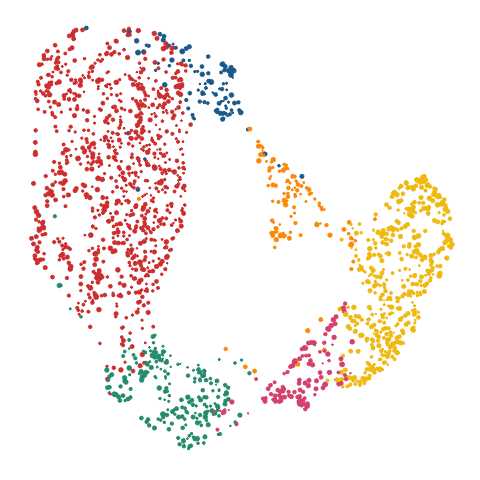

In [ ]:
%%R -i seurat_obj -o seurat_obj

# get the hub gene UMAP table from the seurat object

umap_df <- list()

for (cell_type in names(seurat_obj)){

  print(paste0('Store Module UMAP in hdWGCNA Experiment for ', toupper(cell_type)))

  umap_df[[cell_type]] <- GetModuleUMAP(seurat_obj[[cell_type]])

}

# plot sample for Excitatory cells with ggplot
ggplot(umap_df[[celltypes[1]]], aes(x=UMAP1, y=UMAP2)) +
  geom_point(
   color=umap_df[[celltypes[1]]]$color, # color each point by WGCNA module
   size=umap_df[[celltypes[1]]]$kME*2 # size of each point based on intramodular connectivity
  ) +
  umap_theme()

In [61]:
# convert nested list of Seurat object into Rpy2 object 
seurat_obj =  robjects.ListVector(
                        {
                            cell_type: seurat_obj[cell_type]
                     
                            for cell_type in seurat_obj.keys()
                        }
                    )

In this plot, each point represents a single gene. The size of each dot is scaled by the gene’s kME for it’s assigned module. ggplot2 is sufficient to visualize the genes in the module UMAP, but here we are not visualizing the underlying network. We can use the function ModuleUMAPPlot to plot the genes and their co-expression relationships.

In [83]:
%%R -i seurat_obj -o seurat_obj

fig_dir = paste0("../results/hdWGCNA/HubGeneUMAP/Consensus/")

if (!dir.exists(fig_dir)) {
  dir.create(fig_dir, recursive=TRUE)
}

for (cell_type in names(seurat_obj)){

  print(paste0('UMAP Plot of Connectivities in hdWGCNA Experiment for ', toupper(cell_type)))

  # hubgene network

  pdf(paste0(fig_dir, cell_type, '_consensus_hubgene_umap_igraph.pdf'), width=10, height=10)

  ModuleUMAPPlot(
    seurat_obj[[cell_type]],
    edge.alpha = 0.25,
    sample_edges=TRUE,
    keep_grey_edges=FALSE,
    edge_prop=0.1,  # proportion of edges to sample (10% here) # taking the top 10% strongest edges in each module 
    #label_genes = label_genes,
    label_hubs=2 # how many hub genes to plot per module?
  )
  dev.off()
}

[1] "UMAP Plot of Connectivities in hdWGCNA Experiment for INHIBITORY"
Selecting by kME_INH-M1
Selecting by kME_INH-M2
Selecting by kME_INH-M3
Selecting by kME_INH-M4
Selecting by kME_INH-M5
Selecting by kME_INH-M6
[1] "hub labels"
 [1] "CADPS"   "FGF12"   "FGF14"   "LSAMP"   "CLASP2"  "NCAM1"   "ANKRD36"
 [8] "SNAP25"  "DLG2"    "MAP2"    "ATP8A2"  "DOCK3"  
NULL
 [1] "CADPS"   "FGF12"   "FGF14"   "LSAMP"   "CLASP2"  "NCAM1"   "ANKRD36"
 [8] "SNAP25"  "DLG2"    "MAP2"    "ATP8A2"  "DOCK3"  
[1] 59040     3
[1] 984   4
[1] "making net"
# A tibble: 6 × 5
# Groups:   color [5]
  Var1   Var2    value color   color_alpha
  <fct>  <fct>   <dbl> <chr>   <chr>      
1 HERC6  SLC4A10     0 #f4c40f #F4C40F00  
2 ANK3   ANK3        0 #d8443c #D8443C00  
3 GLUL   UNC80       0 #fe9b00 #FE9B0000  
4 UBQLN2 ANKS1B      0 #1f6e9c #1F6E9C00  
5 SCN1A  SCN1A       0 #de597c #DE597C00  
6 SYT1   SYT1        0 #de597c #DE597C00  
       gene_name module   color  kME_grey kME_INH-M1 kME_INH-M2 kME_INH-M3

In [84]:
# convert nested list of Seurat object into Rpy2 object 
seurat_obj =  robjects.ListVector(
                        {
                            cell_type: seurat_obj[cell_type]
                     
                            for cell_type in seurat_obj.keys()
                        }
                    )

Next, our hypothesis is that the hub genes are the differentially expressed genes that are in the overlapping pathways.

### **Visualizing Hub Genes: Overlapping Pathways and DEGs**

The hub genes, which are also differentially expressed genes (DEGs), can be visualized in the pathways where they overlap. You can find the results of this analysis saved at `f'../results/{test_name}/{study}_{deg_method}_{cell_type}_DEGs_in_overlapping_pathways.csv.csv` from the previous analysis.

Save to pathway names to R

In [79]:
%%R -i test_names -i deg_method -i seurat_obj -o seurat_obj


conflicts_prefer(base::intersect)

fig_dir = paste0("../results/hdWGCNA/HubGeneUMAP/Consensus/")

if (!dir.exists(fig_dir)) {
  dir.create(fig_dir, recursive=TRUE)
}

# label the DEGs in the overlapping pathways

for (test in c('ad_vs_no')){

  print(toupper(test))
  for (cell_type in names(seurat_obj)){

    print(paste0('UMAP Plot of Hub-DEG Connectivities in hdWGCNA Experiment for ', toupper(cell_type)))

    # hubgene network

    overlap_degs <- list()

    for (study in studies){

      overlap_degs[[study]] <- read.csv(paste0('../results/', test, '/', study, '_', deg_method, '_',
                                        cell_type, "_DEGs_in_overlapping_pathways.csv"), header=TRUE)$x
      
                  
    }

    overlap_degs <- unlist(overlap_degs[[study]], recursive=FALSE)

    print(length(overlap_degs))

    hub_genes <- GetHubGenes(seurat_obj[[cell_type]], 25)
    label_genes <- intersect(hub_genes$gene_name, unique(overlap_degs))
    
    if (length(label_genes) == 0) {
      print(paste0('No genes to label for ', toupper(cell_type)))
      print('setting label_genes to NULL')
      label_genes <- NULL
    } else {
      label_genes <- label_genes
    }


    pdf(paste0(fig_dir, test, "_", cell_type, '_overlap_hubDEGs_umap_igraph.pdf'), width=10, height=10)
    ModuleUMAPPlot(
      seurat_obj[[cell_type]],
      edge.alpha=0.25,
      sample_edges=TRUE,
      keep_grey_edges=FALSE,
      edge_prop=0.1,  # proportion of edges to sample (10% here) # taking the top 10% strongest edges in each module 
      label_genes = label_genes,
      label_hubs=0 # how many hub genes to plot per module?
    )
    dev.off()
  }

}



[conflicted] Removing existing preference.
[conflicted] Will prefer base::intersect over any other package.
[1] "AD_VS_NO"
[1] "UMAP Plot of Hub-DEG Connectivities in hdWGCNA Experiment for INHIBITORY"
[1] 191
Selecting by kME_INH-M1
Selecting by kME_INH-M2
Selecting by kME_INH-M3
Selecting by kME_INH-M4
Selecting by kME_INH-M5
Selecting by kME_INH-M6
[1] "hub labels"
 [1] "AAK1"     "AGBL4"    "CACNB4"   "CADPS"    "DTNA"     "FGF12"   
 [7] "MAGI1"    "MAGI2"    "SLC4A10"  "TRIO"     "ADAM22"   "ATXN1"   
[13] "CDK14"    "FGF14"    "LRRC7"    "LSAMP"    "NRCAM"    "RGS7"    
[19] "RIMS1"    "SLC6A1"   "AKAP6"    "AKT3"     "ANK3"     "APP"     
[25] "CLASP2"   "GPHN"     "NCAM1"    "NCOA1"    "RBFOX2"   "TCF4"    
[31] "ANKRD36"  "ATP8A1"   "CELF2"    "CERS6"    "GPM6A"    "NETO1"   
[37] "RAP1GDS1" "SMYD3"    "SNAP25"   "UNC80"    "ANKS1B"   "AUTS2"   
[43] "CADM2"    "DLG2"     "IDS"      "LIMCH1"   "MAP2"     "NBEA"    
[49] "NRXN3"    "RIMS2"    "ATP8A2"   "DOCK3"    "GRIP1"    "

In [78]:
# convert nested list of Seurat object into Rpy2 object 
seurat_obj =  robjects.ListVector(
                        {
                            cell_type: seurat_obj[cell_type]
                     
                            for cell_type in seurat_obj.keys()
                        }
                    )

# **Save Seurat Object**

In [ ]:
%%R -i seurat_obj -o seurat_obj

dat_dir = paste0("../results/hdWGCNA/SeuratObject/Consensus/")

if (!dir.exists(dat_dir)) {
  dir.create(dat_dir, recursive=TRUE)
}

for (cell_type in names(seurat_obj)){
    
    print(paste0('Saving hdWGCNA object in hdWGCNA Experiment for ', toupper(cell_type)))

    saveRDS(seurat_obj[[cell_type]], file=paste0(dat_dir, cell_type, '_hdWGCNA_object.rds'))

}

[1] "Saving hdWGCNA object in hdWGCNA Experiment for EXCITATORY"
[1] "Saving hdWGCNA object in hdWGCNA Experiment for INHIBITORY"
[1] "Saving hdWGCNA object in hdWGCNA Experiment for ASTROCYTE"
[1] "Saving hdWGCNA object in hdWGCNA Experiment for MICROGLIA"
[1] "Saving hdWGCNA object in hdWGCNA Experiment for OLIGODENDROCYTE"


# **Enrichment analysis**

Next, we perform enrichment tests on the hdWGCNA modules. We leverage the R pacakge enrichR to perform enrichment tests on a wide range of curated gene lists. This analysis should point us towards biological processes that our hdWGCNA modules are involved in. Additionally, we perform a gene set overlap analysis to compare the genes in hdWGCNA modules with the marker genes identified using Seurat’s FindAllMarkers function.


## **EnrichR**

hdWGCNA includes the function RunEnrichr to compare the set of genes in each module with any of the gene lists hosted by Enrichr.

The results of the enrichment tests are stored in the hdWGCNA experiment, so can be easily retrieved for downstream analysis or exporting to external applicaitons like Excel. In the following example, we perform the enrichment test with three Gene Ontology datbases:

- `GO_Biological_Process_2021`
- `GO_Cellular_Component_2021`
- `GO_Molecular_Function_2021`

In [78]:
%%R -i seurat_obj -o seurat_obj -o enrich_df

#dbs <- c('GO_Biological_Process_2021')

dbs <- c('GO_Biological_Process_2021','GO_Cellular_Component_2021','GO_Molecular_Function_2021')

enrich_df <- list()

for (cell_type in names(seurat_obj)){

  print(paste0('Estimating Module Enrichments in hdWGCNA Experiment for ', toupper(cell_type)))

  # enrichr databases to test

  # perform enrichment tests
  seurat_obj[[cell_type]] <- RunEnrichr(
    seurat_obj[[cell_type]],
    dbs=dbs, # character vector of enrichr databases to test
    max_genes = 100 # number of genes per module to test
  )
  # retrieve the output table
  enrich_df[[cell_type]] <- GetEnrichrTable(seurat_obj[[cell_type]]) %>% subset(P.value < 0.05)

}

[1] "Estimating Module Enrichments in hdWGCNA Experiment for INHIBITORY"
Selecting by kME_INH-M1
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Selecting by kME_INH-M2
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Selecting by kME_INH-M3
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Selecting by kME_INH-M4
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Selecting by kME_INH-M5
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
Selecting by kME_INH-M6
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


In [79]:
# convert nested list of Seurat object into Rpy2 object 
seurat_obj =  robjects.ListVector(
                        {
                            cell_type: seurat_obj[cell_type]
                     
                            for cell_type in seurat_obj.keys()
                        }
                    )

## **Visualize enrichments**

Now that we have done the enrichment tests, we can now visualize the results.

### **EnrichrBarPlot**

hdWGCNA includes the function EnrichrBarPlot to summarize the results of every Enrichr database and every module. This function outputs a .pdf figure for each module, containing a barplot showing the top N enriched terms. The following example will plot the top 10 terms in each module and will output the results to a folder called enrichr_plots.

In [80]:
%%R -i seurat_obj -o seurat_obj

fig_dir = paste0("../results/hdWGCNA/Enrichr/", save_prefix, '/')

if (!dir.exists(fig_dir)) {
  dir.create(fig_dir, recursive=TRUE)
}

for (cell_type in names(seurat_obj)){

  print(paste0('Enrichr Plots for Modules in hdWGCNA Experiment for ', toupper(cell_type)))

  # make GO term plots:
  EnrichrBarPlot(
    seurat_obj[[cell_type]],
    outdir = paste0(fig_dir, cell_type, "_enrichr_plots"), # name of output directory
    n_terms = 10, # number of enriched terms to show (sometimes more show if there are ties!!!)
    plot_size = c(5,7), # width, height of the output .pdfs
    logscale=TRUE # do you want to show the enrichment as a log scale?
  )
}

[1] "Enrichr Plots for Modules in hdWGCNA Experiment for INHIBITORY"
[1] "INH-M1"
[1] "INH-M2"
[1] "INH-M3"
[1] "INH-M4"
[1] "INH-M5"
[1] "INH-M6"


In [81]:
# convert nested list of Seurat object into Rpy2 object 
seurat_obj =  robjects.ListVector(
                        {
                            cell_type: seurat_obj[cell_type]
                     
                            for cell_type in seurat_obj.keys()
                        }
                    )

### **EnrichrDotPlot**

hdWGCNA includes an additional visualization function for enrichment results, EnrichrDotPlot, which shows the top results for one Enrichr database in each module. In the following example, we plot the top term in the GO_Biological_Process_2021 database.

In [82]:
# %%R -i seurat_obj -o seurat_obj

# fig_dir = '../results/'
# # enrichr dotplot
# p <- EnrichrDotPlot(
#   seurat_obj,
#   mods='all',
#   database = "GO_Biological_Process_2021",
#   n_terms=3,
#   break_ties=TRUE
# )
# pdf(paste0(fig_dir, 'EX_GO_dotplot.pdf'), width=10, height=10, useDingbats=FALSE)
# p
# dev.off()

In [83]:
# # convert nested list of Seurat object into Rpy2 object 
# seurat_obj =  robjects.ListVector(
#                         {
#                             cell_type: seurat_obj[cell_type]
                     
#                             for cell_type in seurat_obj.keys()
#                         }
#                     )

# **Differential module eigengene (DME) analysis**

Here, we perform differential module eigengene (DME) analysis, revealing modules that are up- or down-regulated in given groups of cells.

## **DME analysis comparing two groups**

Here we perform DME testing between two different pathology groups (AD vs control). We use the hdWGCNA function FindDMEs, which is a special case of the Seurat function FindMarkers. We use the Mann-Whitney U test, also known as the Wilcoxon test, to compare two groups, but other tests can be used with the test.use parameter.

FindDMEs requires a list of barcodes for group1 and for group2. We are only going to compare cells from the EX cluster since that is the group that we performed network analysis on.



In [84]:
%%R -i seurat_obj -o seurat_obj -o DMEs

group_col <- 'cell_type'
groups <- celltypes
DMEs <- list()


dat_dir = paste0("../results/hdWGCNA/DMEs/", save_prefix, '/')

if (!dir.exists(dat_dir)) {
  dir.create(dat_dir, recursive=TRUE)
}


for (cell_type in names(seurat_obj)){

  print(paste0('Differential Module Eigengene Analysis in hdWGCNA Experiment for ', toupper(cell_type)))


  # get cell barcodes for this pseudotime bin in control & AD
  g1 <- seurat_obj[[cell_type]]@meta.data[seurat_obj[[cell_type]]$pathology.group %in% c('early', 'late'),] %>% rownames
  g2 <- seurat_obj[[cell_type]]@meta.data[seurat_obj[[cell_type]]$pathology.group == 'no',] %>% rownames

  DMEs[[cell_type]] <- FindDMEs(
          seurat_obj[[cell_type]],
          barcodes1 = g1,
          barcodes2 = g2,
          test.use='wilcox',
          wgcna_name=toupper(substr(cell_type, 1, 3)), # the name of the hdWGCNA experiment,,
          harmonized=TRUE
      )
  
  DMEs[[cell_type]]$group <- cell_type

  # fix infs:
  DMEs[[cell_type]]$avg_log2FC <- ifelse(abs(DMEs[[cell_type]]$avg_log2FC) == Inf, 0, DMEs[[cell_type]]$avg_log2FC)

  write.csv(DMEs[[cell_type]], row.names=FALSE, quote=FALSE, file=paste0(dat_dir, cell_type, '_AD_DMEs.csv'))
}


[1] "Differential Module Eigengene Analysis in hdWGCNA Experiment for INHIBITORY"
[1] 5207    6
[1] "INH-M5" "INH-M4" "INH-M6" "INH-M1" "INH-M3" "INH-M2"


In [85]:
# convert nested list of Seurat object into Rpy2 object 
seurat_obj =  robjects.ListVector(
                        {
                            cell_type: seurat_obj[cell_type]
                     
                            for cell_type in seurat_obj.keys()
                        }
                    )


# convert nested list of Seurat object into Rpy2 object 
DMEs =  robjects.ListVector(
                        {
                            cell_type: DMEs[cell_type]
                     
                            for cell_type in DMEs.keys()
                        }
                    )

We can now visualize the results using the hdWGNCA functions `PlotDMEsLollipop` or `PlotDMEsVolcano`. First we make a lollipop plot to visualize the DME results.


In [86]:
%%R -i seurat_obj -o seurat_obj -i DMEs


fig_dir = paste0("../results/hdWGCNA/DMEs/", save_prefix, '/')

if (!dir.exists(fig_dir)) {
  dir.create(fig_dir, recursive=TRUE)
}


for (cell_type in names(seurat_obj)){

  print(paste0('Lollipop for DMEs in hdWGCNA Experiment for ', toupper(cell_type)))

  pdf(paste0(fig_dir, cell_type, '_dmes_lollipop.pdf'), width=10, height=10)
  p <- PlotDMEsLollipop(
    seurat_obj[[cell_type]], 
    DMEs[[cell_type]], 
    wgcna_name = toupper(substr(cell_type, 1, 3)), # the name of the hdWGCNA experiment,, 
    pvalue = "p_val_adj"
  )
  print(p)
  dev.off()

}

[1] "Lollipop for DMEs in hdWGCNA Experiment for INHIBITORY"
[1] "Please be aware comparison group/groups are not provided, which may casue an ERROR. PlotDMEsLollipop function will automatically assume all values are within the same group."


In [87]:
seurat_obj =  robjects.ListVector(
                        {
                            cell_type: seurat_obj[cell_type]
                     
                            for cell_type in seurat_obj.keys()
                        }
                    )

# **Save Seurat Object**

In [ ]:
%%R -i seurat_obj -o seurat_obj

dat_dir = paste0("../results/hdWGCNA/SeuratObject/Consensus/")

if (!dir.exists(dat_dir)) {
  dir.create(dat_dir, recursive=TRUE)
}

for (cell_type in names(seurat_obj)){
    
    print(paste0('Saving hdWGCNA object in hdWGCNA Experiment for ', toupper(cell_type)))

    saveRDS(seurat_obj[[cell_type]], file=paste0(dat_dir, cell_type, '_hdWGCNA_object.rds'))

}

[1] "Saving hdWGCNA object in hdWGCNA Experiment for EXCITATORY"
[1] "Saving hdWGCNA object in hdWGCNA Experiment for INHIBITORY"
[1] "Saving hdWGCNA object in hdWGCNA Experiment for ASTROCYTE"
[1] "Saving hdWGCNA object in hdWGCNA Experiment for MICROGLIA"
[1] "Saving hdWGCNA object in hdWGCNA Experiment for OLIGODENDROCYTE"
